### Example taken from *A Low-Complexity Quantum Principal Component Analysis Algorithm*
https://doi.org/10.1109/TQE.2021.3140152

In [7]:
import numpy as np
import itertools

from qiskit.visualization import plot_histogram
from qiskit import Aer, transpile, QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.algorithms.linear_solvers.matrices.numpy_matrix import NumPyMatrix
from qiskit.circuit.library import PhaseEstimation
from qiskit.circuit.library.standard_gates import RYGate

In [8]:
example_matrix=np.random.rand(5,5) # N.B. solo matrici con 2**n colonne/righe
example_matrix=np.dot(example_matrix,example_matrix.T)

eig, e_v = np.linalg.eig(example_matrix)
#b=np.array([3.,1.])
b = np.array([2,5,1,3,4])
BB = e_v @ np.diag(b) @ e_v.T

example_matrix=BB

print(f'Matrix: {example_matrix.round(2)}\n')
for eigenval, eigenvec in zip(np.linalg.eig(example_matrix)[0][::-1], np.rot90(np.linalg.eig(example_matrix)[1])):
    print(f'eigenvalue: {eigenval:.0f} - eigenvector: {eigenvec.round(4)}')

Matrix: [[ 3.46  0.04 -0.81 -0.95  0.25]
 [ 0.04  3.23 -0.02 -0.33 -0.72]
 [-0.81 -0.02  3.81  0.41 -1.06]
 [-0.95 -0.33  0.41  2.43  0.63]
 [ 0.25 -0.72 -1.06  0.63  2.07]]

eigenvalue: 4 - eigenvector: [-0.3138 -0.6499 -0.2162  0.4604  0.4696]
eigenvalue: 3 - eigenvector: [-0.518   0.6443 -0.5065  0.2288  0.088 ]
eigenvalue: 2 - eigenvector: [0.5113 0.3582 0.2831 0.6473 0.3332]
eigenvalue: 5 - eigenvector: [-0.5852  0.0383  0.7197  0.2621 -0.2637]
eigenvalue: 1 - eigenvector: [ 0.1713 -0.1811 -0.3142  0.498  -0.7689]


as an example, whose quantum state is given by
$$\left|\psi_{A_0}\right\rangle=\frac{3}{\sqrt{20}}|00\rangle+\frac{1}{\sqrt{20}}|01\rangle+\frac{1}{\sqrt{20}}|10\rangle+\frac{3}{\sqrt{20}}|11\rangle .$$

Note that the eigenvalues and the corresponding eigenvectors obtained by classical PCA are given by
$$\lambda_1=2, u_1=[1,1]^T$$
$$\lambda_2=1, u_2=[−1,1]^T.$$

Note: $[1, 0]^T = |0〉$ and $[0, 1]^T = |1〉.$ 

When we take a threshold τ=1.1 for eigenvalues, the eigenvalue in binary $|λ_1〉=|10〉$ and the corresponding eigenvector $|u_1〉=[1,1]^T=\frac{1}{\sqrt{2}}|0〉+\frac{1}{\sqrt{2}}|1〉$ are considered as principal components. Therefore, the output of the proposed algorithm should be given by

$$\begin{aligned}
\left|\psi_A^{\prime}\right\rangle &=\left|\lambda_1\right\rangle\left|u_1\right\rangle\left|u_1\right\rangle \\
&=|10\rangle \otimes\left(\frac{1}{\sqrt{2}}|0\rangle+\frac{1}{\sqrt{2}}|1\rangle\right) \otimes\left(\frac{1}{\sqrt{2}}|0\rangle+\frac{1}{\sqrt{2}}|1\rangle\right) \\
&=\frac{1}{2}|1000\rangle+\frac{1}{2}|1001\rangle+\frac{1}{2}|1010\rangle+\frac{1}{2}|1011\rangle .
\end{aligned}$$

In [9]:
#Tommaso's great code for computing the thetas
def thetas_computation(example_matrix):
    lst_combination=[]

    sum_squares = (example_matrix**2).sum()
    input_probabilities = (example_matrix**2/sum_squares).flatten()

    for k in range(1, int(np.log2(len(example_matrix)))*2+1):
        lst_combination.append(list(map(list, itertools.product([0, 1], repeat=k))))
    container=[]
    for lst in lst_combination:
        container.append([''.join([''.join(str(j)) for j in i]) for i in lst])
    all_combinations=[item for c in container for item in c]

    general_bitstring=[''.join([''.join(str(j)) for j in i]) for i in list(map(list, itertools.product([0, 1], repeat=int(np.log2(len(example_matrix)))*2)))]

    #Nodes contains all the values of the tree (except for the root)
    nodes=[]
    for st in all_combinations:
        #print(st)
        starts = [general_bitstring.index(l) for l in general_bitstring if l.startswith(st)]
        #print(starts)
        print(st,'->',np.sqrt(input_probabilities[starts].sum()))
        nodes.append(np.sqrt(input_probabilities[starts].sum()))
    print(nodes)
    #add root tree
    nodes.insert(0, 1)

    idx_sub=1
    thetas=[]
    for i in range(len(nodes)-len(input_probabilities)):
        right_node=i+idx_sub
        left_node=right_node+1
        #print(left_node,right_node)
        if nodes[i]!=0:
            #print(nodes[right_node],nodes[i])
            thetas.append(2*np.arccos(nodes[right_node]/nodes[i]))
            thetas.append(2*np.arcsin(nodes[left_node]/nodes[i]))
        else:
            thetas.append(0)
            thetas.append(0)

        idx_sub+=1
    return thetas, all_combinations

# SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")

# for idx,th in zip(all_combinations,thetas):
#     print('\u03F4(R{})'.format((str(idx).translate(SUB))),'->', th)
#thetas

In [10]:
def generate_qram_circuit(thetas, all_combinations):
    
    right_nodes_indexes=list(range(0,len(thetas),2))
    rotations_list=list(zip(np.array(all_combinations)[right_nodes_indexes],np.array(thetas)[right_nodes_indexes]))

    qc=QuantumCircuit(len(example_matrix))

    for r_l in rotations_list:
        target_qubit=len(r_l[0])-1
        
        #First case of R_0
        if target_qubit==0:
            qc.ry(theta=r_l[1],qubit=target_qubit)
            continue
            
        not_gate=[]
        for qb in range(target_qubit):
            if r_l[0][qb]=='0':
                not_gate.append(qb)
                
        c_t_qubits=list(range(len(r_l[0])))
        n_controls=len(range(target_qubit))
        
        if len(not_gate)>0:
            qc.x(not_gate)
            c_ry = RYGate(r_l[1]).control(n_controls)
            qc.append(c_ry, c_t_qubits)
            qc.x(not_gate)
        else:
            c_ry = RYGate(r_l[1]).control(n_controls)
            qc.append(c_ry, c_t_qubits)
    return qc

In [11]:
thetas, all_combinations = thetas_computation(example_matrix)
matrix_circuit = generate_qram_circuit(thetas, all_combinations)
# matrix_circuit.draw()

0 -> 0.6615290328117331
1 -> 0.5714985696278408
00 -> 0.49655348283718065
01 -> 0.43709873019158135
10 -> 0.15321478720393586
11 -> 0.5505777366264647
000 -> 0.4669965052733377
001 -> 0.1687590749566484
010 -> 0.034674191887497714
011 -> 0.4357212415662585
100 -> 0.10722006301561778
101 -> 0.10944692368849064
110 -> 0.5160004601781428
111 -> 0.19204001969554563
0000 -> 0.4669683794172147
0001 -> 0.005125286525723254
0010 -> 0.10941509196723817
0011 -> 0.12848331810015062
0100 -> 0.03429330869251685
0101 -> 0.005125286525723254
0110 -> 0.43571324698403047
0111 -> 0.0026394610576983674
1000 -> 0.04458698128868102
1001 -> 0.0975097072738702
1010 -> 0.10941509196723817
1011 -> 0.0026394610576983375
1100 -> 0.5130683705093302
1101 -> 0.0549301564439404
1110 -> 0.1427284349197491
1111 -> 0.12848331810015062
[0.6615290328117331, 0.5714985696278408, 0.49655348283718065, 0.43709873019158135, 0.15321478720393586, 0.5505777366264647, 0.4669965052733377, 0.1687590749566484, 0.034674191887497714, 0

In [54]:
#Check matrix encoding
backend = Aer.get_backend("statevector_simulator")
job = backend.run(transpile(matrix_circuit, backend=backend))
# job.result().get_counts()

In [55]:
#Unitary for PE
resolution = 3

unitary_backend = Aer.get_backend("unitary_simulator")
u_circuit = NumPyMatrix(example_matrix, evolution_time=2*np.pi/(2**resolution))
unitary_job = unitary_backend.run(transpile(u_circuit, backend=unitary_backend))
unitary_job.result().get_unitary()

C:\Users\emanu\AppData\Local\Temp\ipykernel_19108\4091163410.py:5: DeprecationWarning: The NumPyMatrix class is deprecated as of Qiskit Terra 0.22.0 and will be removed no sooner than 3 months after the release date. 
  u_circuit = NumPyMatrix(example_matrix, evolution_time=2*np.pi/(2**resolution))


Operator([[-0.08070133+0.80516976j, -0.22483717-0.54280494j],
          [-0.22483717-0.54280494j, -0.62640545-0.51227654j]],
         input_dims=(2,), output_dims=(2,))

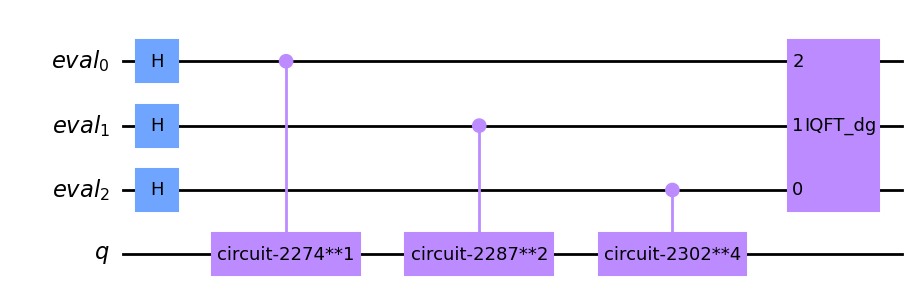

In [56]:
#PE circuit
pe = PhaseEstimation(resolution, u_circuit, name = "PE")
pe.decompose().draw("mpl")

# Check Statevector

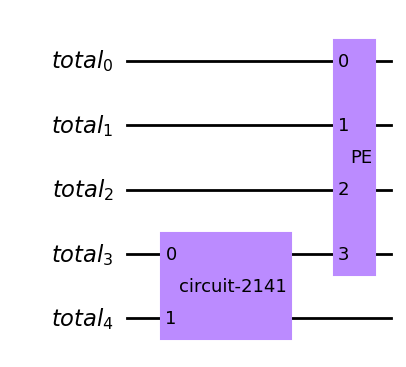

In [57]:
tot_qubit = resolution+len(example_matrix)

qr_total = QuantumRegister(tot_qubit, 'total')
# classical = ClassicalRegister(4, 'measure')

total_circuit = QuantumCircuit(qr_total , name='matrix')

total_circuit.append(matrix_circuit.to_gate(), qr_total[resolution:])
total_circuit.append(pe.to_gate(), qr_total[0:pe.num_qubits])
# total_circuit.measure(qr_total[:2], classical[:])
#total_circuit.swap(qr_total[0],qr_total[1])
#total_circuit.measure_all()

total_circuit.decompose(reps=0).draw("mpl")

In [58]:
backend_total = Aer.get_backend("statevector_simulator")
job = backend_total.run(transpile(total_circuit, backend=backend_total))
statevector = np.asarray(job.result().get_statevector()).round(4)
#plot_histogram(counts)

In [59]:
def attach_bitstrings(vector):
    return zip(bitstrings, vector)

bitstrings=[''.join([''.join(str(j)) for j in i]) for i in list(map(list, itertools.product([0, 1], repeat=resolution+len(example_matrix))))]
ss=attach_bitstrings(statevector)

real_statevector_dictionary = {}
for el in ss:
    real_statevector_dictionary[el[0]]=el[1]

{key : real_statevector_dictionary[key] for key in real_statevector_dictionary.keys() if real_statevector_dictionary[key] != 0.0}


{'00010': (0.329+0j),
 '00101': (0.106+0j),
 '01010': (-0.1181-0j),
 '01101': (0.2952+0j),
 '10010': (-0.1181-0j),
 '10101': (0.2952+0j),
 '11010': (0.0424-0j),
 '11101': (0.8225+0j)}

# Computing Probabilities

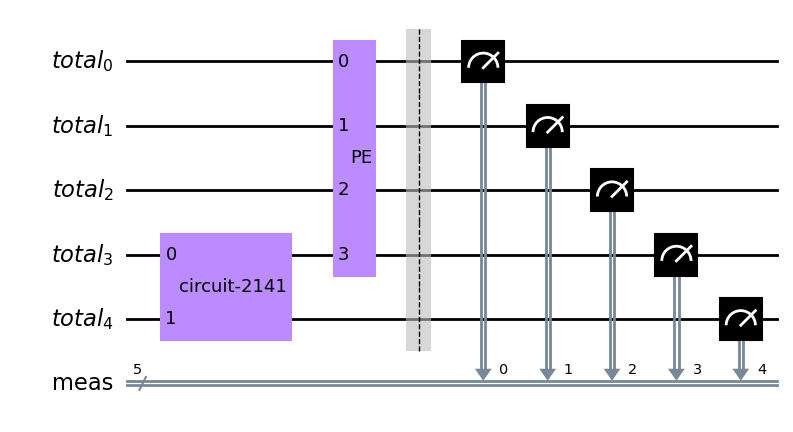

In [60]:
tot_qubit = resolution+len(example_matrix)

qr_total = QuantumRegister(tot_qubit, 'total')
# classical = ClassicalRegister(4, 'measure')

total_circuit_1 = QuantumCircuit(qr_total , name='matrix')

total_circuit_1.append(matrix_circuit.to_gate(), qr_total[resolution:])
total_circuit_1.append(pe.to_gate(), qr_total[0:pe.num_qubits])
# total_circuit.measure(qr_total[:2], classical[:])
#total_circuit_1.swap(qr_total[0],qr_total[1])
total_circuit_1.measure_all()

total_circuit_1.decompose(reps=0).draw("mpl")

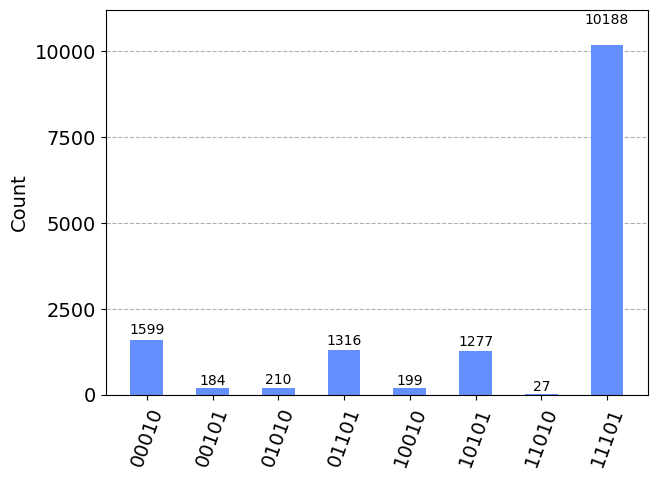

In [61]:
n_shots = 15000
backend_total = Aer.get_backend("qasm_simulator")
job = backend_total.run(transpile(total_circuit_1, backend=backend_total), shots=n_shots)
counts = job.result().get_counts()
plot_histogram(counts)

# Storing probabilities

In [62]:
for i in counts:
    counts[i]/=n_shots
# counts

In [63]:
statevector=np.zeros(2**tot_qubit)
for i in counts:
    statevector[int(i,2)]=counts[i]
# statevector

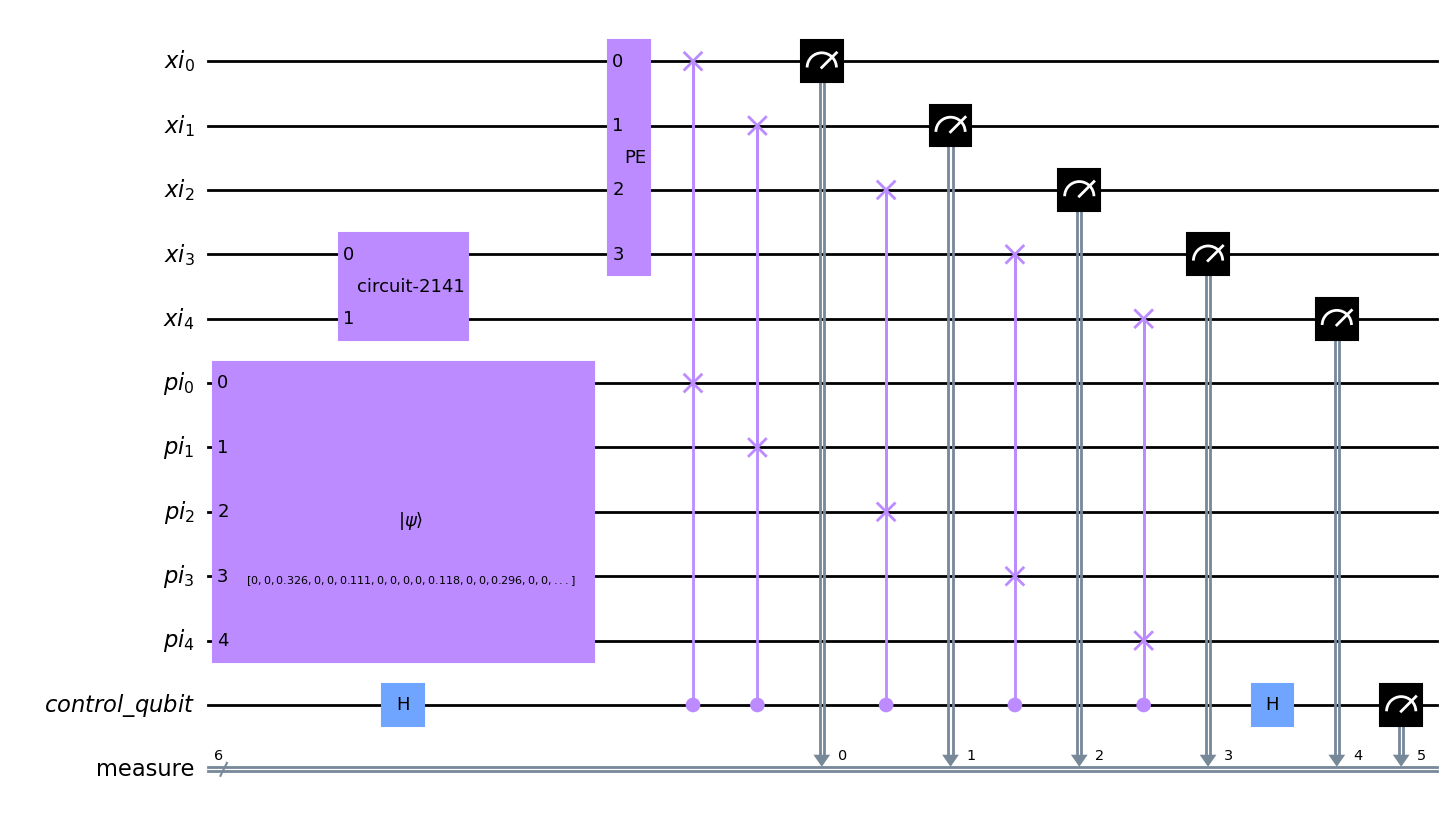

In [64]:

tot_qubit = resolution+len(example_matrix)

qr_total_xi = QuantumRegister(tot_qubit, 'xi')
qr_total_pi = QuantumRegister(tot_qubit, 'pi')
qr_control = QuantumRegister(1, 'control_qubit')
n_classical_register=tot_qubit+1
classical = ClassicalRegister(n_classical_register, 'measure')

total_circuit_2 = QuantumCircuit(qr_total_xi,qr_total_pi,qr_control ,classical, name='matrix')

total_circuit_2.append(matrix_circuit.to_gate(), qr_total_xi[resolution:])
total_circuit_2.append(pe.to_gate(), qr_total_xi[0:pe.num_qubits])

#total_circuit_2.swap(qr_total_xi[0],qr_total_xi[1])
total_circuit_2.initialize(np.sqrt(statevector),qr_total_pi)
total_circuit_2.h(qr_control)
for i in range(tot_qubit):
    total_circuit_2.cswap(control_qubit=qr_control, target_qubit1=qr_total_xi[i],target_qubit2=qr_total_pi[i])

total_circuit_2.h(qr_control)
total_circuit_2.measure(qr_total_xi,classical[0:n_classical_register-1])
total_circuit_2.measure(qr_control,classical[n_classical_register-1])

total_circuit_2.draw("mpl")

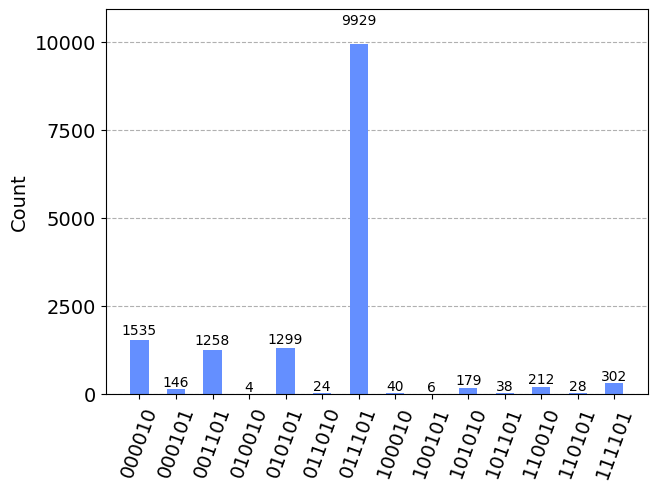

In [65]:
backend_total = Aer.get_backend("qasm_simulator")
job = backend_total.run(transpile(total_circuit_2, backend=backend_total), shots=n_shots)
counts_for_sign = job.result().get_counts()
plot_histogram(counts_for_sign)

In [66]:
#Take only counts with control qubits equal to 0
tmp=np.zeros(2**tot_qubit)
for c in counts_for_sign:
    if c[0]=='0':
        tmp[int(c[1:],2)]=counts_for_sign[c]
# tmp
# statevector

In [67]:
#Sign estimation
sign_dictionary={}
sign=0
for e, (count, prob) in enumerate(zip(tmp, statevector)):
    if count>0.4*prob*n_shots:
        sign=1
    else:
        sign=-1
    if prob==0:
        sign=0
    sign_dictionary.update({bin(e)[2:].zfill(tot_qubit):sign})

# sign_dictionary

In [68]:
statevector_dictionary={}
for e,key in enumerate(sign_dictionary):
    statevector_dictionary[key]=sign_dictionary[key]*np.sqrt(statevector[e])

{key : round(statevector_dictionary[key], 4) for key in statevector_dictionary.keys() if statevector_dictionary[key] != 0.0}

{'00010': 0.3265,
 '00101': 0.1108,
 '01010': -0.1183,
 '01101': 0.2962,
 '10010': -0.1152,
 '10101': 0.2918,
 '11010': 0.0424,
 '11101': 0.8241}

# Eigenvectors reconstruction (2x2 matrix)


In [73]:
statevector_dictionary = real_statevector_dictionary
binary_lambda=[]
for d in statevector_dictionary:
    if statevector_dictionary[d]!=0:
        binary_lambda.append(d[-resolution:])
l_list=[]
eigenvalues=[]
for b_l in np.unique(binary_lambda):
    eigenvalues.append(int(b_l[::-1],2))
    tmp_list=[]
    for key in list(statevector_dictionary.keys()):
        if key[-resolution:]==b_l:
            tmp_list.append(statevector_dictionary[key])
    l_list.append(np.asarray(tmp_list))
l_list

[array([ 0.329 +0.j, -0.1181-0.j, -0.1181-0.j,  0.0424-0.j]),
 array([0.106 +0.j, 0.2952+0.j, 0.2952+0.j, 0.8225+0.j])]

In [75]:
for l in l_list:
    normalization_factor=np.sqrt((1/(sum(l**2))))
    l*=normalization_factor

# Eigenvectors Reconstruction (Generalized)

In [76]:
#TODO: Capire se fare la media tra i vari fattori di rescaling
eigenvectors=[]
for ll, eig in zip(l_list,eigenvalues):
    #print(ll,eig)
    # eigenvector=np.zeros(len(example_matrix)) #put length of eigenvector
    save_sign=np.sign(ll)
    statevector=abs(ll)
    max_list=[]
    scaled_statevectors=[]
    for e,i in enumerate(range(0,len(statevector),len(example_matrix))):
        max_list.append(max(statevector[i:i+len(example_matrix)]))
        scaled_statevectors.append(statevector[i:i+len(example_matrix)]/max_list[e])
        #print(max_list,scaled_statevectors)
    idx_max=np.argmax(max_list)
    #print(idx_max)
    max_max=max_list[idx_max]
    #print(max_max)
    value=np.sqrt(max_max)
    eigenvector=scaled_statevectors[idx_max]*value*save_sign[:len(example_matrix)]
    eigenvectors.append(eigenvector)
    # print(eigenvector)
    print(f'eigenvalue: {eig} - eigenvector: {eigenvector.round(3)}')    

eigenvalue: 2 - eigenvector: [ 0.941+0.j -0.338+0.j]
eigenvalue: 5 - eigenvector: [0.338+0.j 0.941+0.j]


In [77]:
for eigenval, eigenvec in zip(np.linalg.eig(example_matrix)[0][::-1], np.rot90(np.linalg.eig(example_matrix)[1])):
    print(f'eigenvalue: {eigenval:.0f} - eigenvector: {eigenvec.round(3)}')
# np.linalg.eig(example_matrix)

eigenvalue: 5 - eigenvector: [-0.338 -0.941]
eigenvalue: 2 - eigenvector: [-0.941  0.338]


Nota: l'autovettore di una matrice è un vettore che mantiene la sua direzione quando viene trasformato dalla matrice. Moltiplicare ogni componente dell'autovettore per -1 inverte solo la direzione del vettore, ma mantiene la sua relazione con la trasformazione data dalla matrice. Pertanto, un autovettore moltiplicato per -1 resta ancora un autovettore della stessa matrice.

Nota 2 (soglia): è possibile conoscere la somma degli autovalori di una matrice senza calcolare gli autovalori. Un modo per farlo è usare la traccia della matrice, che è definita come la somma degli elementi della diagonale della matrice. La traccia di una matrice è uguale alla somma dei suoi autovalori.

# Non eseguire le prossime celle-> si riferiscono ai conti fatti dopo

In [ ]:
l_list

[array([ 0.02487923, -0.18736271,  0.01880693,  0.05719904, -0.10680283,
         0.909369  , -0.09862437, -0.31413765, -0.01628728,  0.08669566,
         0.        , -0.03118776,  0.        ,  0.06649254, -0.00940346,
        -0.02487923]),
 array([ 0.88370213,  0.07377497, -0.4228159 ,  0.03393155,  0.01772018,
         0.        ,  0.        ,  0.        ,  0.14395938,  0.01023075,
        -0.05877117, -0.01023075,  0.08681077,  0.        , -0.03688749,
        -0.01023075]),
 array([ 0.16746511, -0.07463575,  0.2775365 , -0.3508948 , -0.15862936,
         0.06789746, -0.29854301,  0.3754879 , -0.08081414,  0.04157853,
        -0.13148287,  0.16162829, -0.21336447,  0.11428846, -0.37497599,
         0.50544481]),
 array([0.10582468, 0.11233706, 0.25719353, 0.21691459, 0.1532455 ,
        0.16856757, 0.38357703, 0.33125843, 0.09255428, 0.09803553,
        0.22772225, 0.18934909, 0.1831797 , 0.20604706, 0.4646188 ,
        0.39553735])]

In [ ]:
np.linalg.eig(example_matrix)

(array([3.00000000e+00, 2.00000000e+00, 1.00000000e+00, 1.38840214e-16]),
 array([[-0.27283206, -0.89909441,  0.32289714,  0.11370725],
        [-0.30415742, -0.07818057, -0.14423829, -0.93838765],
        [-0.69638872,  0.42791917,  0.56686168,  0.1029358 ],
        [-0.58999464, -0.04901247, -0.74404341,  0.30968291]]))

$$\left|11\right\rangle(0.1058|0000\rangle+0.1123|0001\rangle+0.2571|0010\rangle+0.2169|0011\rangle+
0.1532|0100\rangle+0.1685|0101\rangle+0.3835|0110\rangle+0.3312|0111\rangle+0.09255|1000\rangle+0.09803|1001\rangle+0.2277|1010\rangle+0.1893|1011\rangle+
0.1831|1100\rangle+0.2060|1101\rangle+0.4646|1110\rangle+0.3955|1111\rangle) =$$

$$\left|11\right\rangle\left[\textbf{0.2571|00}\rangle(0.41|00\rangle+0.43|01\rangle+|10\rangle+0.84|11\rangle)+\\
\textbf{0.3835|01}\rangle(0.399|00\rangle+0.48|01\rangle+|10\rangle+0.86|11\rangle)+\\
\textbf{0.2277|01}\rangle(0.40|00\rangle+0.43|01\rangle+|10\rangle+0.83|11\rangle)+\\
\textbf{0.4646|01}\rangle(0.39|00\rangle+0.44|01\rangle+|10\rangle+0.8|11\rangle)\right]\\
$$

$$\sqrt{0.4646}=0.68 -> 3 posizione 
\\
0.68*0.39=0.265-> 1 posizione
\\
0.68*0.44=0.29 -> 2 posizione
\\
0.68*0.8=0.54 -> 4 posizione
$$




$$\left|10\right\rangle(0.1674|0000\rangle-0.0746|0001\rangle+0.27753|0010\rangle-0.3508|0011\rangle-0.1586|0100\rangle+0.06789|0101\rangle-0.2985|0110\rangle+0.3754|0111\rangle-0.08081|1000\rangle+0.04157|1001\rangle-0.1314|1010\rangle+0.1616|1011\rangle-0.2133|1100\rangle+0.11428|1101\rangle-0.3749|1110\rangle+0.50544|1111\rangle) =$$


$$\left|10\right\rangle\left[\textbf{0.3508|00}\rangle(0.4771|00\rangle-0.2126|01\rangle+0.7911|10\rangle-|11\rangle)-\\
\textbf{0.3754|01}\rangle(0.4224|00\rangle-0.187|01\rangle+0.7951|10\rangle-|11\rangle)-\\
\textbf{0.1616|10}\rangle(0.50|00\rangle-0.26|01\rangle+0.8131|10\rangle-|11\rangle)-\\
\textbf{0.50544|10}\rangle(0.42|00\rangle-0.22|01\rangle+0.75|10\rangle-|11\rangle)\right]=
$$


$$
\sqrt{0.50544}=\approx0.71 -> 4 posizione 
\\
0.71*0.42=0.29-> 1 posizione
\\
0.68*0.22=0.15 -> 2 posizione
\\
0.68*0.75=... -> 3 posizione
$$

Magari possiamo fare una media dei vari rapporti. Per esempio: (0.4771+0.4224+0.50+0.42)/4=x. Dopodichè moltiplicare la radice del massimo dei massimi (0.71 in quest'ultimo caso) per x invece che per 0.42 per trovare il valore della prima posizione dell'eigenvector.

Prendiamo sempre il massimo dei massimi perchè è quello che viene influenzato meno da eventuali errori di approssimazione (?)





In [ ]:
l_list

[array([0.4241215 , 0.61471659, 0.37664376, 0.54807294]),
 array([ 0.81858522, -0.56242645, -0.09622978,  0.06583729])]

In [ ]:
np.linalg.eig(example_matrix)

(array([3., 1.]),
 array([[ 0.82363923,  0.56711412],
        [-0.56711412,  0.82363923]]))

$$\left|10\right\rangle(0.4241|00\rangle+0.6147|01\rangle+0.3766|10\rangle+0.5480|11\rangle) =$$

$$\left|10\right\rangle(0.6147|0\rangle(0.689|0\rangle+|1\rangle)+0.5480|1\rangle(0.687|0\rangle+|1\rangle)) =$$

$$\sqrt{0.6147}=0.7840 -> posizione 1$$ 

$$0.7840*0.689=0.5401 -> posizione 0$$




## 1st matrix_example

In [ ]:
norm_up=np.sqrt((1/(sum(np.asarray(list(statevector_dictionary_up_threshold.values()))**2))))
norm_down=np.sqrt((1/(sum(np.asarray(list(statevector_dictionary_down_threshold.values()))**2))))
for k in statevector_dictionary_up_threshold:
    statevector_dictionary_up_threshold[k]*=norm_up
    
    
for k_d in statevector_dictionary_down_threshold:
    statevector_dictionary_down_threshold[k_d]*=norm_down
statevector_dictionary_up_threshold,statevector_dictionary_down_threshold, np.linalg.eig(example_matrix)

({'0001': 0.4063074844837685,
  '0101': -0.4947759382402847,
  '1001': -0.48985675123506794,
  '1101': 0.5917358889406178},
 {'0011': 0.5898840122966107,
  '0111': 0.49452547412185405,
  '1011': 0.4915537016695547,
  '1111': 0.4072546695329175},
 (array([3., 1.]),
  array([[ 0.76746056, -0.64109616],
         [ 0.64109616,  0.76746056]])))

$$\left|01\right\rangle(0.4063|00\rangle-0.4947|01\rangle-0.4898|10\rangle+0.5917|11\rangle) =$$

$$\left|01\right\rangle(0.4063|0\rangle(|0\rangle-1.21|1\rangle)-0.4898|1\rangle(|0\rangle-x|1\rangle)) =$$

$$\left|01\right\rangle((0.4063|0\rangle-0.4898|1\rangle)(|0\rangle-x|1\rangle)) =$$

$$\left|01\right\rangle(0.4063(|0\rangle-y|1\rangle)(|0\rangle-x|1\rangle)) =>$$

$$\sqrt{0.5917}=0.7692$$

$$0.7692*\approx0.8*\text{sign}\left|1\right\rangle=-0.6153$$




$$\left|11\right\rangle(0.5898|00\rangle+0.4945|01\rangle+0.4915|10\rangle+0.4072|11\rangle) =$$

$$\left|11\right\rangle(0.5898|0\rangle(|0\rangle+0.83|1\rangle)+0.4915|1\rangle(|0\rangle+0.83|1\rangle)) =$$

$$\left|11\right\rangle((0.5898|0\rangle+0.4915|1\rangle)(|0\rangle+0.83|1\rangle)) =$$

$$\left|11\right\rangle(0.5898(|0\rangle+0.83|1\rangle)(|0\rangle+0.83|1\rangle)) =>$$

$$\sqrt{0.5898}=0.7679$$

$$0.7679*\approx0.8*\text{sign}\left|0\right\rangle=0.6143$$




## 2nd matrix_example

$$\left|01\right\rangle(0.1272|00\rangle-0.3143|01\rangle-0.3203|10\rangle+0.8845|11\rangle) =$$

$$\left|01\right\rangle(0.3143|0\rangle(0.40|0\rangle-|1\rangle)-0.8845|1\rangle(0.36|0\rangle-|1\rangle)) =$$

$$\left|01\right\rangle((0.3143|0\rangle-0.8845|1\rangle)(0.4|0\rangle-|1\rangle)) =$$

$$\left|01\right\rangle(0.8845(0.36|0\rangle-|1\rangle)(0.4|0\rangle-|1\rangle)) =>$$

$$\sqrt{0.8845}=0.9404$$

$$0.9404*\approx0.4*\text{sign}\left|1\right\rangle=-0.3761$$




## 3d matrix_example

In [ ]:
norm_up=np.sqrt((1/(sum(np.asarray(list(statevector_dictionary_up_threshold.values()))**2))))
norm_down=np.sqrt((1/(sum(np.asarray(list(statevector_dictionary_down_threshold.values()))**2))))
for k in statevector_dictionary_up_threshold:
    statevector_dictionary_up_threshold[k]*=norm_up
    
    
for k_d in statevector_dictionary_down_threshold:
    statevector_dictionary_down_threshold[k_d]*=norm_down
statevector_dictionary_up_threshold,statevector_dictionary_down_threshold, np.linalg.eig(example_matrix)

({'0001': 0.36710092124099825,
  '0101': 0.6614992335357107,
  '1001': 0.3149078628268718,
  '1101': 0.5731393509308969},
 {'0011': 0.8721533545579773,
  '0111': -0.4889160360072559,
  '1011': 0.013630169512202875,
  '1111': -0.011128986804178979},
 (array([3., 1.]),
  array([[ 0.87370608,  0.4864542 ],
         [-0.4864542 ,  0.87370608]])))

$$\left|01\right\rangle(0.3671|00\rangle+0.6614|01\rangle+0.3149|10\rangle+0.5731|11\rangle) =$$

$$\left|01\right\rangle(0.6614|0\rangle(0.55|0\rangle+|1\rangle)+0.5731|1\rangle(0.55|0\rangle+|1\rangle)) =$$

$$\left|01\right\rangle((0.6614|0\rangle+0.5731|1\rangle)(0.55|0\rangle+|1\rangle)) =$$

$$\left|01\right\rangle(0.6614(|0\rangle+\approx0.8|1\rangle)(0.55|0\rangle-|1\rangle)) =>$$

$$\sqrt{0.6614}=\approx0.81$$

$$0.81*\approx0.55*\text{sign}\left|1\right\rangle=\approx0.44$$




$$\left|11\right\rangle(0.8721|00\rangle-0.4889|01\rangle+0.0136|10\rangle-0.0111|11\rangle) =$$

$$\left|11\right\rangle(0.8721|0\rangle(|0\rangle-\approx0.5|1\rangle)+0.0136|1\rangle(|0\rangle-\approx0.8|1\rangle)) =$$

$$\left|11\right\rangle((0.8721|0\rangle+0.0136|1\rangle)(|0\rangle-\approx0.5|1\rangle)) =$$

$$\left|11\right\rangle(0.8721(|0\rangle+0.0155|1\rangle)(|0\rangle-0.5|1\rangle)) =>$$

$$\sqrt{0.8721}=\approx0.93$$

$$0.93*\approx0.5*\text{sign}\left|0\right\rangle=\approx0.44$$




## 4th matrix_example

In [ ]:
norm_up=np.sqrt((1/(sum(np.asarray(list(statevector_dictionary_up_threshold.values()))**2))))
norm_down=np.sqrt((1/(sum(np.asarray(list(statevector_dictionary_down_threshold.values()))**2))))
for k in statevector_dictionary_up_threshold:
    statevector_dictionary_up_threshold[k]*=norm_up
    
    
for k_d in statevector_dictionary_down_threshold:
    statevector_dictionary_down_threshold[k_d]*=norm_down
statevector_dictionary_up_threshold,statevector_dictionary_down_threshold, np.linalg.eig(example_matrix)

({'0001': 0.06844207564752064,
  '0101': -0.2434477406836873,
  '1001': -0.26237207143606917,
  '1101': 0.9312409870529826},
 {'0011': 0.9317470599478411,
  '0111': 0.2529050552183149,
  '1011': 0.251498062074687,
  '1111': 0.06808211289503242},
 (array([3., 1.]),
  array([[ 0.96521162, -0.26146994],
         [ 0.26146994,  0.96521162]])))

$$\left|11\right\rangle(0.93|00\rangle+0.25|01\rangle+0.25|10\rangle+0.068|11\rangle) =$$

$$\left|11\right\rangle(0.93|0\rangle(|0\rangle+\approx0.26|1\rangle)+0.25|1\rangle(|0\rangle+0.2|1\rangle)) =$$

$$\left|11\right\rangle((0.93|0\rangle+0.25|1\rangle)(|0\rangle+\approx0.2|1\rangle)) =$$

$$\left|11\right\rangle(0.93(|0\rangle+0.2|1\rangle)(|0\rangle+0.2|1\rangle)) =>$$

$$\sqrt{0.93}=\approx0.96$$

$$0.96*\approx0.2*\text{sign}\left|0\right\rangle=\approx0.25$$


